This notebook generates the figures for Chapter 5: Single-subject statistical analysis from Poldrack, Mumford, and Nichols' _Handbook of fMRI Data Analysis (2nd Edition)_

In [81]:
import os,sys,shutil
from wand.image import Image as WImage
import numpy
import scipy.stats
import matplotlib.pyplot as plt
import nilearn.plotting
%matplotlib inline
import nibabel
from nipype.interfaces import fsl
from nipy.modalities.fmri.hemodynamic_models import spm_hrf,compute_regressor
from statsmodels.tsa.arima_process import arma_generate_sample
from __future__ import division

from nipype.caching import Memory
# use nipype's caching mechanism to save the results of the processing
mem = Memory(base_dir='.')

# set up rpy2 so we can use R magic
%load_ext rpy2.ipython

datadir=os.getenv('FMRIBOOKDATA')
if not datadir:
    raise Exception('You need to set the environment variable FMRIBOOKDATA')
else:
    print 'using base dir:',datadir
sys.path.append('../../utils')

from get_data import get_data
data=get_data()

orig_figuredir='https://web.stanford.edu/group/poldracklab/fmri-handbook-2e-data/figures-1e/'

figuredir='../../figures'
if not os.path.exists(figuredir):
    os.mkdir(figuredir)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
using base dir: /Users/poldrack/data/fmri-handbook-2e-data


__Figure 5.1__: Illustration of BOLD timeseries against boxcar.  _NOTE_: Fix error in caption in book

In [2]:
data=numpy.loadtxt(os.path.join(datadir,'filt_func_block_27_8_15.txt'))

stim=numpy.zeros((data.shape[0],1))
for i in range(10,data.shape[0],20):
    stim[i:i+10,0]=1
X=numpy.hstack((stim - numpy.mean(stim),numpy.ones((data.shape[0],1))))
bhat=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data.T)
pred=X.dot(bhat)

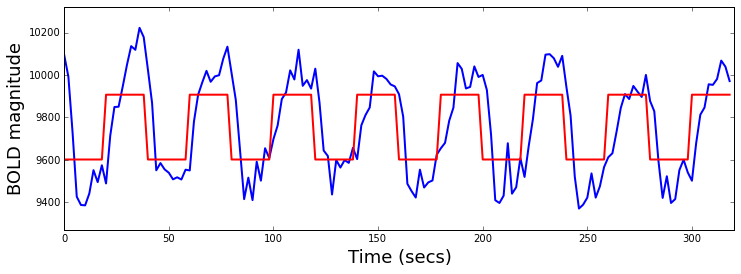

In [3]:
plt.figure(figsize=(12,4))
timepoints=numpy.arange(data.shape[0])*2.0
plt.plot(timepoints,data,linewidth=2)
plt.axis([0,data.shape[0]*2,numpy.min(data)-100,numpy.max(data)+100])
plt.plot(timepoints,pred,color='red',linewidth=2)
plt.ylabel('BOLD magnitude',fontsize=18)
plt.xlabel('Time (secs)',fontsize=18)
plt.savefig(os.path.join(figuredir,'Figure_5_1.svg'),format='svg',dpi=1200)

__Figure 5.2__: use original manually generated image

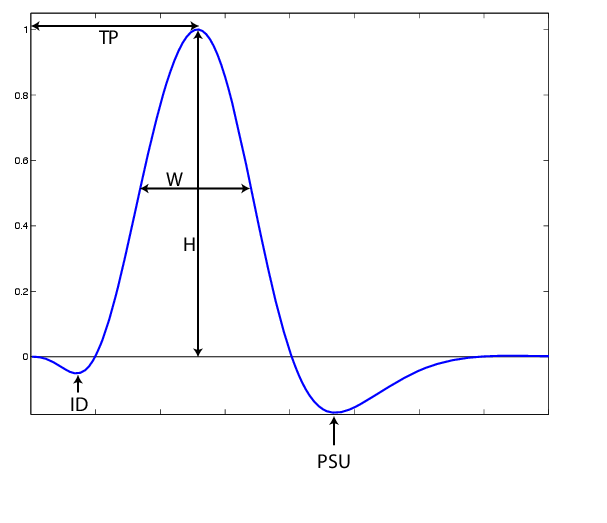

In [4]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_2.pdf'))

__Figure 5.3__: Examples of linear time invariance.  _NOTE_: add full color description to caption in book

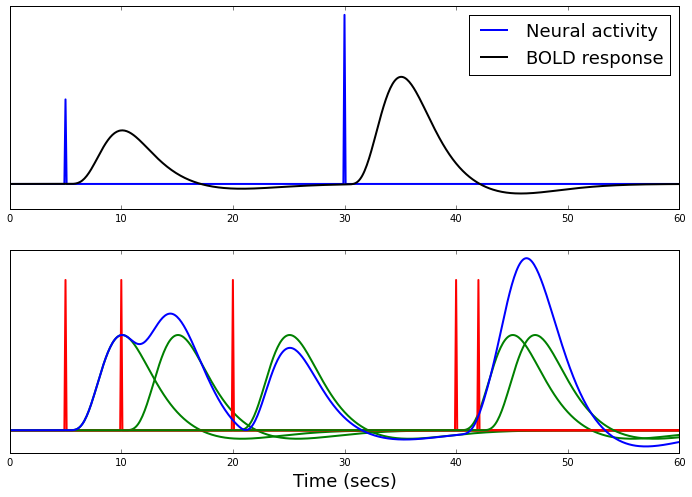

In [5]:
tr=0.1
tslen=60 # secs
ts=numpy.zeros(tslen/tr)
ts[numpy.round(5/0.1)]=1
ts[numpy.round(30/0.1)]=2
tsconv=numpy.convolve(ts,spm_hrf(tr,oversampling=1))[:len(ts)]

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
timepoints=numpy.arange(0,60,tr)
plt.plot(timepoints,ts/30.,linewidth=2)
plt.plot(timepoints,tsconv,color='black',linewidth=2)
plt.legend(['Neural activity','BOLD response'],fontsize=18)
plt.yticks([])
plt.subplot(2,1,2)

stimtimes=[5,10,20,40,42]
tsconv_sum=numpy.zeros(ts.shape)
for s in stimtimes:
    ts=numpy.zeros(tslen/tr)
    ts[s/tr]=1
    tsconv=numpy.convolve(ts,spm_hrf(tr,oversampling=1))[:len(ts)]
    tsconv_sum+=tsconv
    plt.plot(timepoints,ts/30.,linewidth=2,color='red')

    plt.plot(timepoints,tsconv,color='green',linewidth=2)

plt.plot(timepoints,tsconv_sum,linewidth=2,color='blue')
plt.xlabel('Time (secs)',fontsize=18)
plt.yticks([])
plt.savefig(os.path.join(figuredir,'Figure_5_3.svg'),format='svg',dpi=1200)

__Figure 5.4__: Example of selective averaging

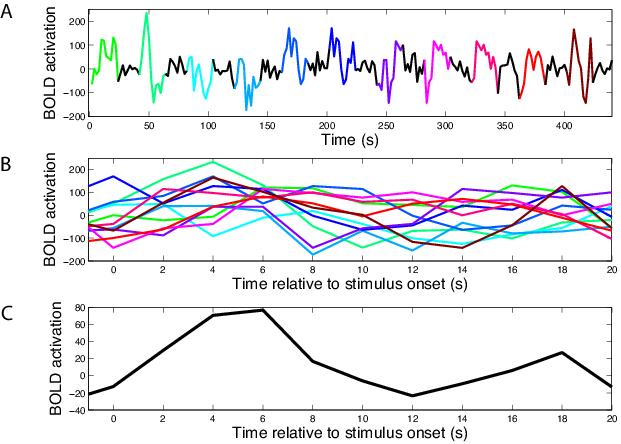

In [6]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_4.pdf'))


(1, 460)


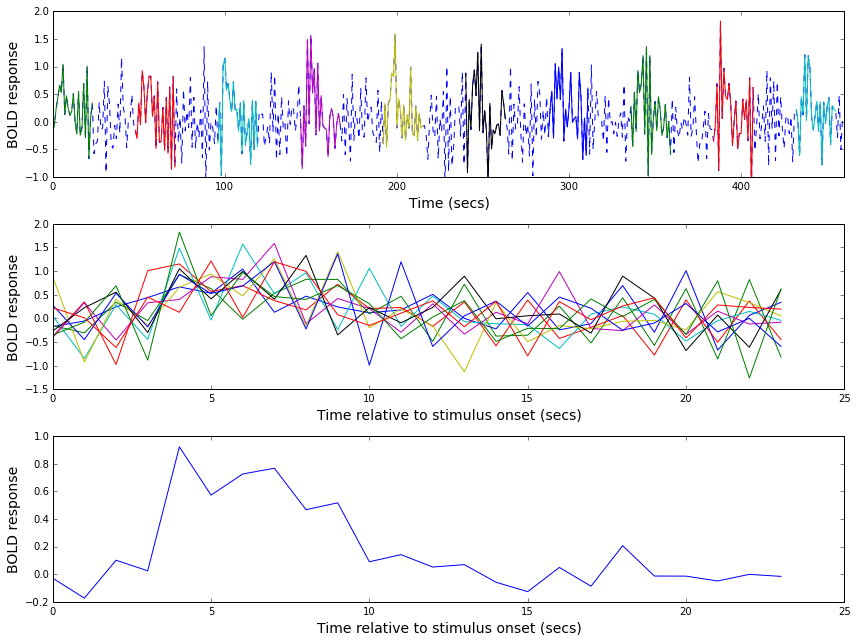

In [7]:
# generate simulated single-trial data
tslen=460
times=numpy.arange(0,tslen,48)
design=(times,numpy.ones(times.shape),numpy.ones(times.shape))
regressor,_=compute_regressor(design,'spm',numpy.arange(0,tslen))

ar1_noise=arma_generate_sample([1,0.6],[1,0.],len(regressor))
beta=4
y=regressor.T*beta + ar1_noise*0.4
print y.shape
plt.figure(figsize=(12,9))
plt.subplot(3,1,1)
plt.axis([0,tslen,-1.,2.])
plt.plot(y.T,'--')
plt.xlabel('Time (secs)',fontsize=14)
plt.ylabel('BOLD response',fontsize=14)
trialdata=None
for i in design[0]:
    plt.plot(numpy.arange(i,i+24),y.T[i:i+24])
    try:
        trialdata=numpy.hstack((trialdata,y.T[i:i+24]))
    except:
        trialdata=y.T[i:i+24]
        
plt.subplot(3,1,2)
plt.plot(trialdata)
plt.xlabel('Time relative to stimulus onset (secs)',fontsize=14)
plt.ylabel('BOLD response',fontsize=14)
plt.subplot(3,1,3)
plt.plot(numpy.mean(trialdata,1))
plt.xlabel('Time relative to stimulus onset (secs)',fontsize=14)
plt.ylabel('BOLD response',fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figuredir,'Figure_5_4.svg'),format='svg',dpi=1200)

__Figure 5.5__: Example of different basis functions fit to a block design response

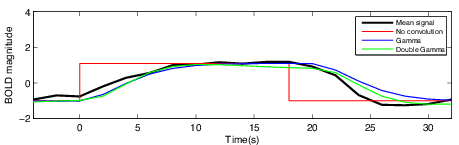

In [8]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_5.pdf'))


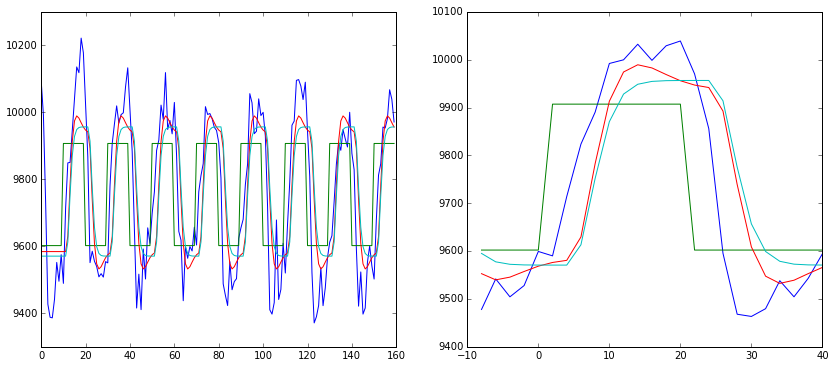

In [9]:
data=numpy.loadtxt(os.path.join(datadir,'filt_func_block_27_8_15.txt'))
boxcar=numpy.zeros(len(data))
onsets=[10, 30, 50, 70, 90, 110, 130, 150]  # in TRs
for i in onsets:
    boxcar[i:i+10]=1

conv_spm=numpy.convolve(boxcar,spm_hrf(2,1))[:len(data)]

from scipy.stats import gamma
# adapted from nipy.modalities.fmri.hemodynamic_models
def gamma_hrf(tr, oversampling=16, time_length=32., onset=0.,
                         delay=6, undershoot=16., dispersion=1.,
                         u_dispersion=1.):
    """ Compute an hrf as the difference of two gamma functions
    Parameters
    ----------
    tr: float, scan repeat time, in seconds
    oversampling: int, temporal oversampling factor, optional
    time_length: float, hrf kernel length, in seconds
    onset: float, onset of the hrf
    Returns
    -------
    hrf: array of shape(length / tr * oversampling, float),
         hrf sampling on the oversampled time grid
    """
    dt = tr / oversampling
    time_stamps = numpy.linspace(0, time_length, float(time_length) / dt)
    time_stamps -= onset / dt
    hrf = gamma.pdf(time_stamps, delay / dispersion, dt / dispersion) 
    hrf /= hrf.sum()
    return hrf

conv_gamma=numpy.convolve(boxcar,gamma_hrf(2,1))[:len(data)]

# fit models to data
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(data)
X_boxcar=numpy.hstack((boxcar.T[:,numpy.newaxis],numpy.ones((len(data),1))))
beta_boxcar=numpy.linalg.inv(X_boxcar.T.dot(X_boxcar)).dot(X_boxcar.T.dot(data))
pred_boxcar=X_boxcar.dot(beta_boxcar)
plt.plot(pred_boxcar)
X_spm=numpy.hstack((conv_spm.T[:,numpy.newaxis],numpy.ones((len(data),1))))
beta_spm=numpy.linalg.inv(X_spm.T.dot(X_spm)).dot(X_spm.T.dot(data))
pred_spm=X_spm.dot(beta_spm)
plt.plot(pred_spm)
X_gamma=numpy.hstack((conv_gamma.T[:,numpy.newaxis],numpy.ones((len(data),1))))
beta_gamma=numpy.linalg.inv(X_gamma.T.dot(X_gamma)).dot(X_gamma.T.dot(data))
pred_gamma=X_gamma.dot(beta_gamma)
plt.plot(pred_gamma)

blockresp=None
blockresp_spm=None
blockresp_gamma=None
blockresp_boxcar=None

# get mean block response
for i in onsets[:-1]:
    try:
        blockresp=numpy.vstack((blockresp,data[(i-5):(i+20)]))
        blockresp_spm=numpy.vstack((blockresp_spm,pred_spm[(i-5):(i+20)]))
        blockresp_gamma=numpy.vstack((blockresp_gamma,pred_gamma[(i-5):(i+20)]))
        blockresp_boxcar=numpy.vstack((blockresp_boxcar,pred_boxcar[(i-5):(i+20)]))
    except:
        blockresp=data[i-5:i+20]
        blockresp_spm=pred_spm[i-5:i+20]
        blockresp_gamma=pred_gamma[i-5:i+20]
        blockresp_boxcar=pred_boxcar[i-5:i+20]
    
plt.subplot(1,2,2)
pst=numpy.arange(-8,42,2)
plt.plot(pst,numpy.mean(blockresp,0))
plt.plot(pst,numpy.mean(blockresp_boxcar,0))
plt.plot(pst,numpy.mean(blockresp_spm,0))
plt.plot(pst,numpy.mean(blockresp_gamma,0))

plt.savefig(os.path.join(figuredir,'Figure_5_5.svg'),format='svg',dpi=1200)

__Figure 5.6__: Example of temporal derivative (_NOTE_: time axis was incorrect in previous edition)

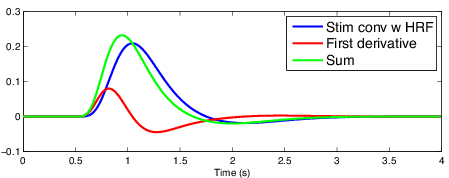

In [10]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_6.pdf'))


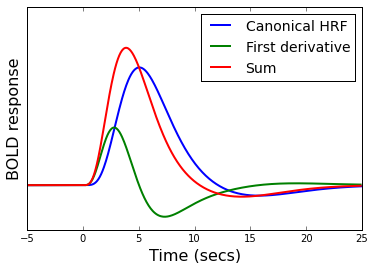

In [11]:
timepoints=numpy.arange(-5,25,1/16.)
ts=numpy.zeros(len(timepoints))
ts[16*5]=1
hrf=spm_hrf(1.)
tsconv=numpy.convolve(ts,hrf)[:len(ts)]
plt.plot(timepoints,tsconv,linewidth=2)
deriv=tsconv[1:]-tsconv[:-1]
plt.plot(timepoints[:-1],deriv*20,linewidth=2)
plt.plot(timepoints[:-1],tsconv[:-1]+deriv*20,linewidth=2)
plt.legend(['Canonical HRF','First derivative','Sum'],fontsize=14)
plt.xlabel('Time (secs)',fontsize=16)
plt.yticks([])
plt.ylabel('BOLD response',fontsize=16)
plt.savefig(os.path.join(figuredir,'Figure_5_6.svg'),format='svg',dpi=1200)

__Figure 5.7__: Example of FIR model: Use original manually generated figure


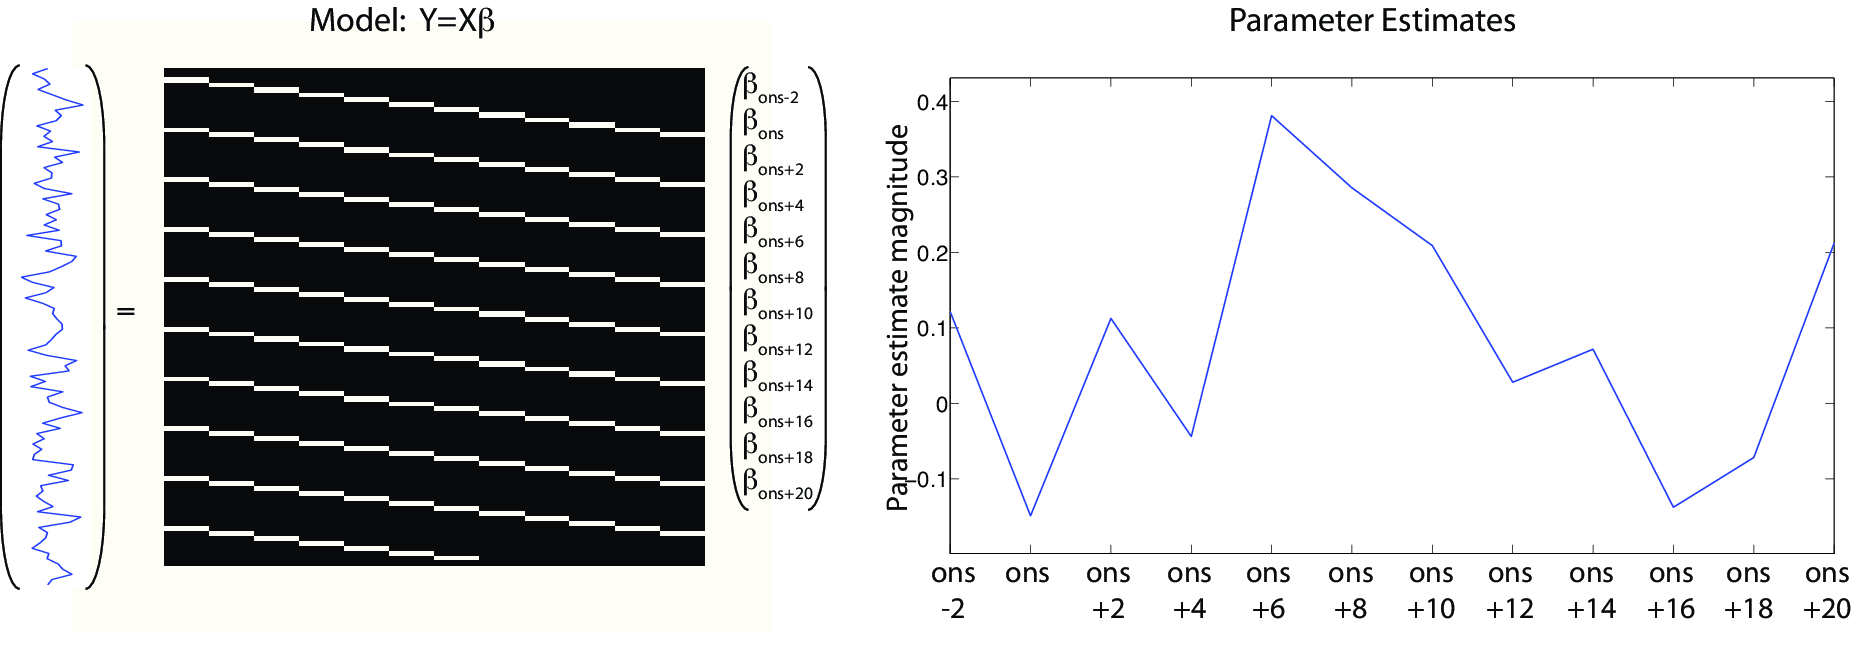

In [12]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_7.pdf'))


__Figure 5.8__: Example of FLOBS basis

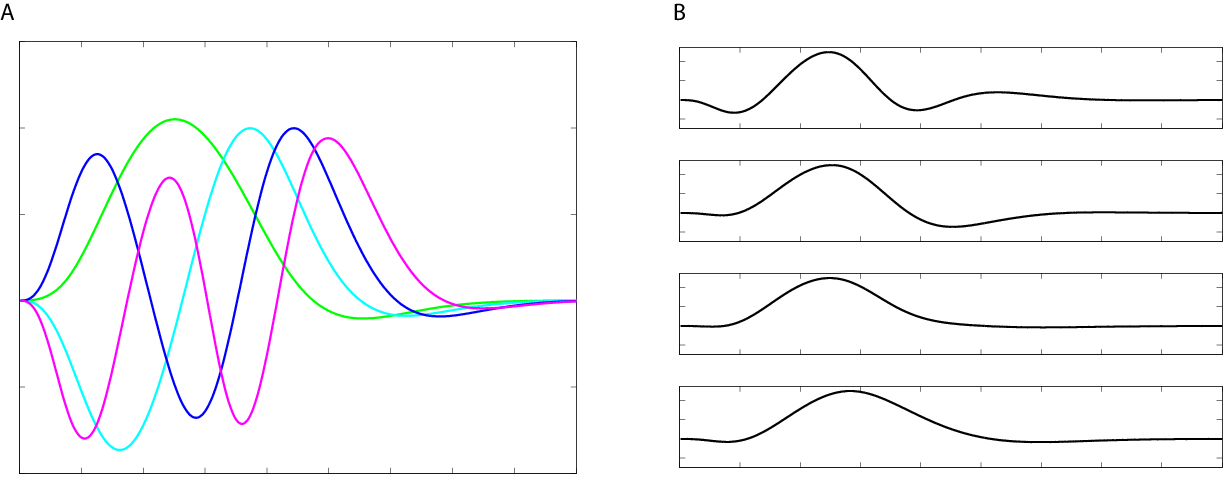

In [13]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_8.pdf'))


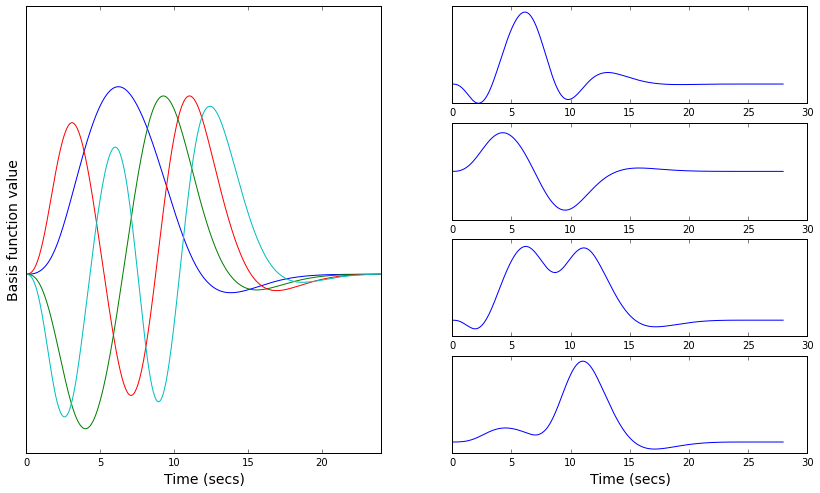

In [14]:
from __future__ import division
plt.figure(figsize=(14,8))
ax1 = plt.subplot2grid((4,2), (0,0), rowspan=4,colspan=1)
flobs=numpy.loadtxt(os.path.join(datadir,'hrfbasisfns.txt'))
plt.axis([0,24,-0.1,0.15])
timepoints=numpy.arange(0,28,28/flobs.shape[0])
plt.plot(timepoints,flobs)
plt.xlabel('Time (secs)', fontsize=14)
plt.yticks([])
plt.ylabel('Basis function value', fontsize=14)

fit1=numpy.array([0.1049,   -0.0263,   -0.0417,    0.0716])
ax2 = plt.subplot2grid((4,2), (0,1))
plt.plot(timepoints,flobs.dot(fit1))
plt.yticks([])
fit2=.8*numpy.array([0.1049,   -0.63,   -0.0417 ,   0.01])
ax3 = plt.subplot2grid((4,2), (1,1))
plt.plot(timepoints,flobs.dot(fit2))
plt.yticks([])
fit3=.4*numpy.array([0.5,   0.2263,   0.217,    0.2716])
ax4 = plt.subplot2grid((4,2), (2,1))
plt.plot(timepoints,flobs.dot(fit3))
plt.yticks([])
fit4=numpy.array([0.1,   0.15,   0.217,    0.1])
ax5 = plt.subplot2grid((4,2), (3,1))
plt.plot(timepoints,flobs.dot(fit4))
plt.yticks([])
plt.xlabel('Time (secs)', fontsize=14)
plt.savefig(os.path.join(figuredir,'Figure_5_8.svg'),format='svg',dpi=1200)

__Figure 5.9__: Example of fitting data with various basis sets

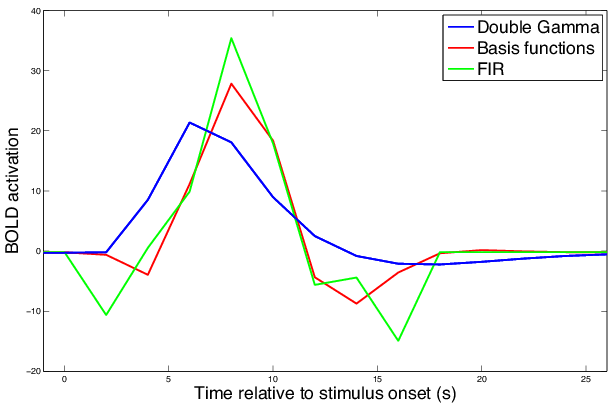

In [15]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_9.pdf'))



[ 0.53403586]


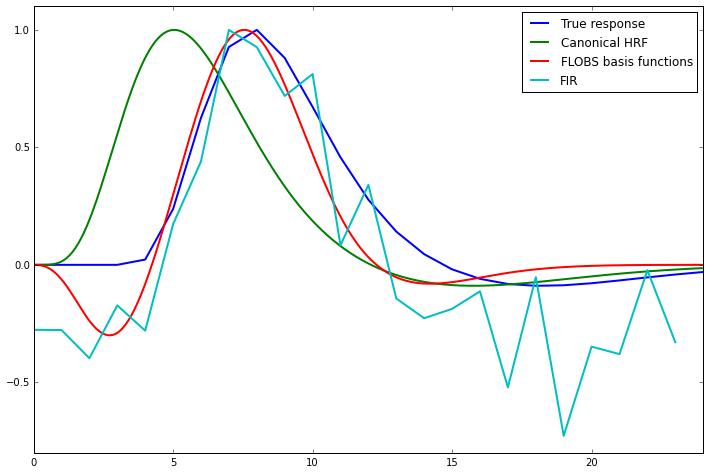

In [16]:
# first generate some data using a specific response shape
tslength=480
tr=1.
ts=numpy.zeros(tslength)
# make an evenly spaced event-related design
onsets=numpy.arange(10,tslength,24)  

def make_fir_model(onsets,tslength,hrflength=24,tr=1):
    """
    generate an FIR model design matrix
    """
    try:
        assert tr==1
    except:
        raise Exception('right now only works properly for tr==1, need to generalize')
        
    X=numpy.zeros((tslength,hrflength/tr))
    for i in range(hrflength):
        for o in onsets:
            try:
                X[o+i,i]=1
            except:
                pass
    return X

hrf=spm_hrf(1.,oversampling=1)
# shift the HRF by 2 secs to the right
hrf[2:]=hrf[:-2]
hrf[:2]=0

fir_X=make_fir_model(onsets,tslength)
data=fir_X.dot(hrf[:fir_X.shape[1]]) + arma_generate_sample([1,0.6],[1,0.],fir_X.shape[0])*0.1
data=data-numpy.mean(data) # demean so that we don't need a constant in the model

# fit the data using canonical, flobs, and FIR model
design=(onsets,numpy.ones(onsets.shape),numpy.ones(onsets.shape))
spmhrf_X,_=compute_regressor(design,'spm',numpy.arange(0,tslength))
spm_beta=numpy.linalg.lstsq(spmhrf_X,data)[0]
print spm_beta

fir_beta=numpy.linalg.lstsq(fir_X,data)[0]

# FLOBS is oversampled at 0.05 secs (20X)
flobs=numpy.loadtxt(os.path.join(datadir,'hrfbasisfns.txt'))

from nipy.modalities.fmri.hemodynamic_models import _sample_condition 
from scipy.interpolate import interp1d

sf_highres,hr_frametimes=_sample_condition(design,numpy.arange(0,tslength*tr,0.05),
                                            oversampling=1,min_onset=0)
frametimes=numpy.arange(0,tslength,1)

flobs_X=numpy.zeros((tslength,flobs.shape[1]))
for i in range(flobs.shape[1]):
    c=numpy.convolve(sf_highres,flobs[:,i])[:len(sf_highres)]
    f = interp1d(hr_frametimes, c)
    conv_lr=f(frametimes)
    flobs_X[:,i]=conv_lr
plt.figure(figsize=(12,8))
plt.plot(numpy.arange(0,32,1),hrf/numpy.max(hrf),label='True response',linewidth=2)
plt.axis([0,24,-0.8,1.1])

spm_resp=spm_hrf(1.,oversampling=20)[:480]
plt.plot(numpy.arange(0,24,0.05),spm_resp/numpy.max(spm_resp),label='Canonical HRF',linewidth=2)

flobs_beta=numpy.linalg.lstsq(flobs_X,data)[0]
flobs_resp=flobs.dot(flobs_beta)
plt.plot(numpy.arange(0,28,0.05),flobs_resp/numpy.max(flobs_resp),label='FLOBS basis functions',linewidth=2)

plt.plot(fir_beta/numpy.max(fir_beta),label='FIR',linewidth=2)
plt.legend()
plt.savefig(os.path.join(figuredir,'Figure_5_9.svg'),format='svg',dpi=1200)

__Figure 5.10__:  Illustrating why convolution is performed in a higher resolution time domain than the TR. The left panel shows different stimuli, with timings indicated in the legend, convolved with the double gamma HRF in a high resolution time domain. The right panel illustrates the result that would be acquired for all 4 stimuli if convolution was done in the lower time resolution of 3s (black dashed line) compared to the signals that are acquired by down sampling the higher resolution signals from the left hand panel (solid colored lines).


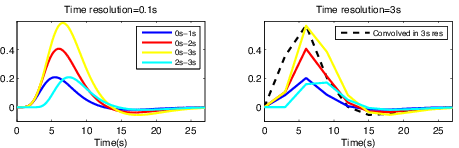

In [17]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_10.pdf'))


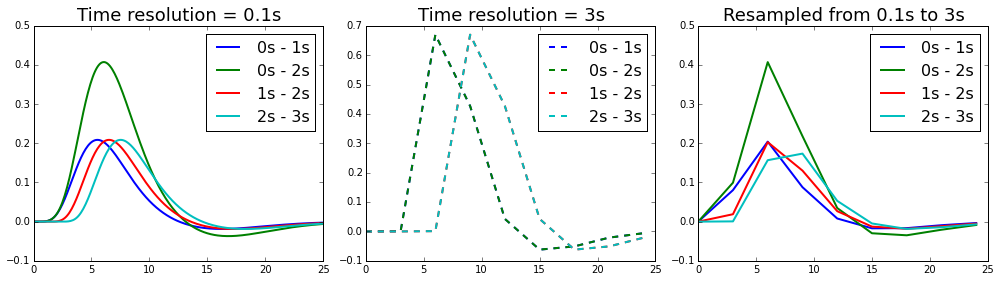

In [175]:
onsets=[0,0,1,2]
durations=[1,2,1,1]
npts=25
regressors_high=numpy.zeros((250,len(onsets)))
regressors_low=numpy.zeros((9,len(onsets)))

for i in range(len(onsets)):
    design=([onsets[i]],[durations[i]],[1])
    rh,_=compute_regressor(design,'spm',numpy.arange(0,25,0.1),oversampling=10)
    rl,_=compute_regressor(design,'spm',numpy.arange(0,25,3),oversampling=1)
    regressors_high[:,i]=rh[:,0]
    regressors_low[:,i]=rl[:,0]

legendtext=['0s - 1s ','0s - 2s','1s - 2s','2s - 3s']
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(numpy.arange(0,25,0.1),regressors_high,linewidth=2)
plt.title('Time resolution = 0.1s',fontsize=18)
plt.legend(legendtext,fontsize=16)
plt.subplot(1,3,2)
#plt.plot(numpy.arange(0,25,3),regressors_high[range(0,len(regressors_high),30)],linewidth=2)
plt.plot(numpy.arange(0,25,3),regressors_low,linewidth=2,linestyle='--')
plt.title('Time resolution = 3s',fontsize=18)
plt.legend(legendtext,fontsize=16)
plt.subplot(1,3,3)
plt.plot(numpy.arange(0,25,3),regressors_high[range(0,len(regressors_high),30)],linewidth=2)
plt.title('Resampled from 0.1s to 3s',fontsize=18)
plt.legend(legendtext,fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(figuredir,'Figure_5_10.svg'),format='svg',dpi=1200)

__Figure 5.11__: Construction of a parametrically modulated regressor

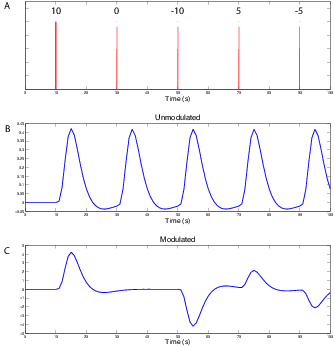

In [18]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_11.pdf'))


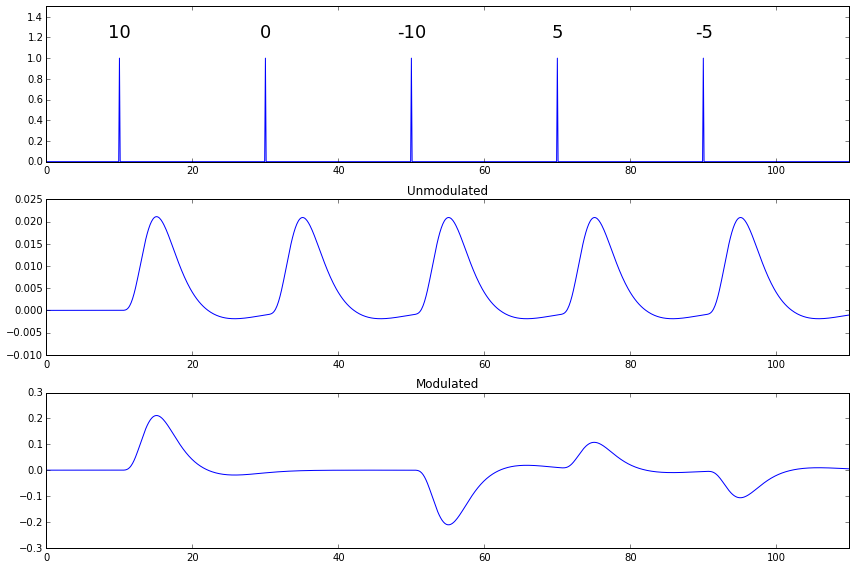

In [125]:
ts=numpy.zeros(1100)
timepoints=numpy.arange(0,110,0.1)
onsets=[100,300,500,700,900]
tr=0.1
ts[onsets]=1
parametric=[10,0,-10,5,-5]
tsp=numpy.zeros(1100)
tsp[onsets]=parametric

plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(timepoints,ts)
plt.axis([0,110,0,1.5])
#plt.text(onsets*tr,1.2,'test')
for i in range(len(parametric)):
    plt.text(onsets[i]*tr,1.2,'%d'%parametric[i],fontsize=18,horizontalalignment='center')
    
plt.subplot(3,1,2)
hrf=spm_hrf(1.,oversampling=10)
conv=numpy.convolve(ts,hrf)
plt.plot(timepoints,conv[:len(timepoints)])
plt.axis([0,110,-0.01,0.025])
plt.title('Unmodulated')

plt.subplot(3,1,3)
hrf=spm_hrf(1.,oversampling=10)
conv=numpy.convolve(tsp,hrf)
plt.plot(timepoints,conv[:len(timepoints)])
plt.axis([0,110,-0.3,0.3])
plt.title('Modulated')

plt.tight_layout()
plt.savefig(os.path.join(figuredir,'Figure_5_11.svg'),format='svg',dpi=1200)

__Figure 5.12__: Example of orthogonalization

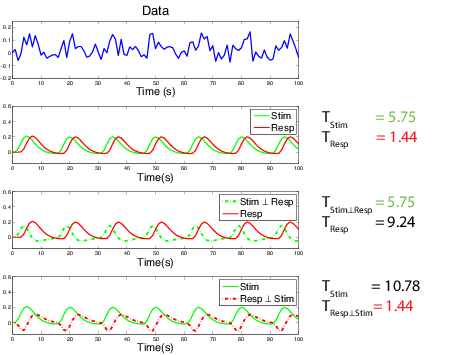

In [20]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_12.pdf'))


__Figure 5.13__: Noise structure of fMRI data. The left panel shows the BOLD time series for a voxel that exhibits both signal (blocked pattern is visible) as well as low frequency drift in the form of a slow uphill trend. The right panel shows the same data in the frequency domain. The red line corresponds to the shape of a fitted 1/ f function, which matches the shape of the power spectrum well and the spike in the power spectrum at 0.025 Hz corresponds to the frequency of the task (once every 40s) in this experiment.

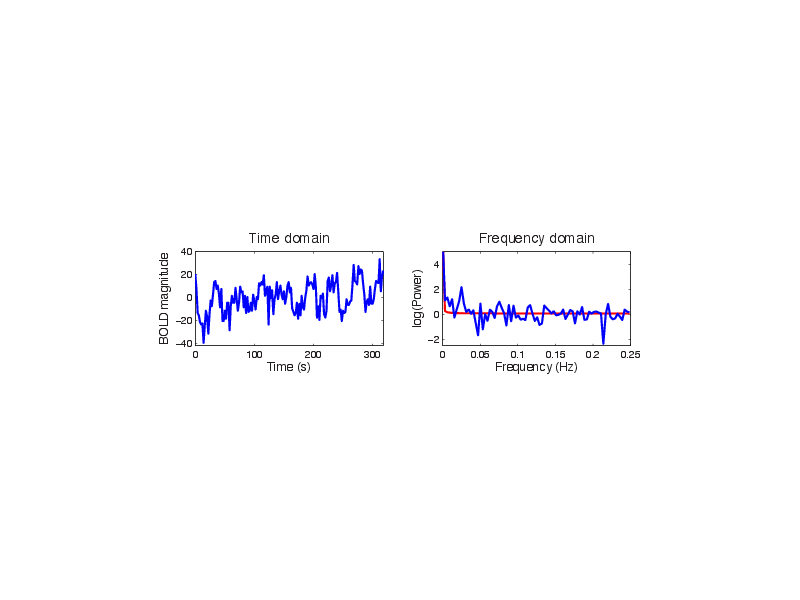

In [21]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_13.pdf'))


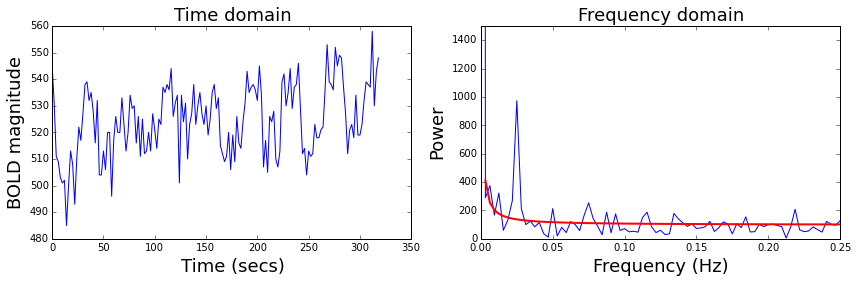

In [124]:
def powerspectrum(ts,rate=1./2.,log=True):
    powerspec = numpy.abs(numpy.fft.rfft(ts))
    if log:
        powerspec=numpy.log10(powerspec)
    f = numpy.fft.rfftfreq(len(ts), d=1/rate)
    return powerspec,f

from scipy.optimize import curve_fit

ts=numpy.loadtxt(os.path.join(datadir,'drift_olp_01_1_25_7_16.txt'))
timepoints=numpy.arange(0,2.*len(ts),2.)
rate=1./2. #1.16

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(timepoints,ts)
plt.title('Time domain',fontsize=18)
plt.xlabel('Time (secs)',fontsize=18)
plt.ylabel('BOLD magnitude',fontsize=18)
plt.subplot(1,2,2)
power_ts,f = powerspectrum(ts,rate,log=False)
plt.plot(f,power_ts)
plt.title('Frequency domain',fontsize=18)
plt.xlabel('Frequency (Hz)',fontsize=18)
plt.ylabel('Power',fontsize=18)

def one_over_f(i,a,b):
    """ 1/f**a with nonzero intercept"""
    return 1./(i**a)+b

fit=curve_fit(one_over_f,f[1:],power_ts[1:],p0=[0.3,0.0])
plt.plot(f,one_over_f(f,fit[0][0],fit[0][1]),linewidth=2,color='red')
plt.axis([0,0.25,0,1500])

plt.tight_layout()
plt.savefig(os.path.join(figuredir,'Figure_5_13.svg'),format='svg',dpi=1200)

__Figure 5.14__: DCT basis set

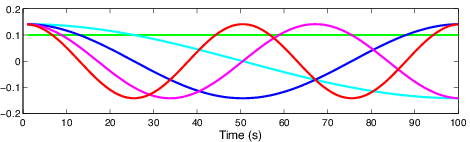

In [22]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_14.pdf'))


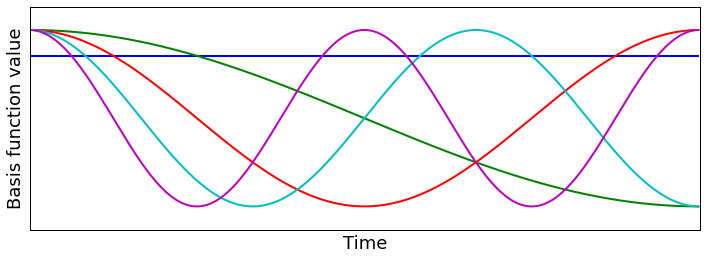

In [23]:
def spm_dctmtx(N,K):
    """ 
    implementation of spm_dctmtx.m (missing some options from original)
    N=dimension
    K=order
    """
    n=numpy.arange(0,N,1)
    C = numpy.zeros((len(n),K))
    C[:,0]     = numpy.ones(len(n))/numpy.sqrt(N)
    for k in range(1,K):
        C[:,k] = numpy.sqrt(2./float(N))*numpy.cos(numpy.pi*(2.*n+1)*(k)/(2.*N))

    return C

plt.figure(figsize=(12,4))
plt.plot(spm_dctmtx(500,5),linewidth=2)
plt.xticks([])
plt.yticks([])
plt.xlabel('Time',fontsize=18)
plt.ylabel('Basis function value',fontsize=18)
plt.savefig(os.path.join(figuredir,'Figure_5_14.svg'),format='svg',dpi=1200)

__Figure 5.15__: Illustration of high-pass filtering

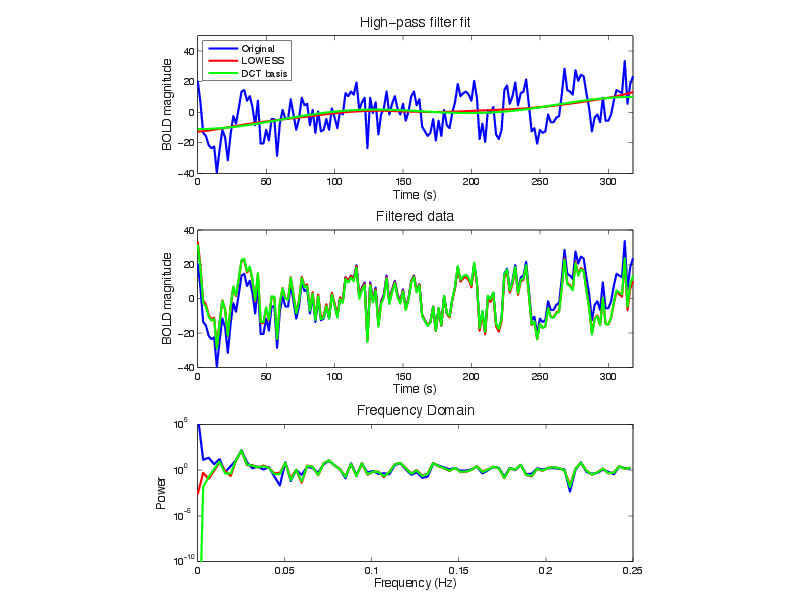

In [24]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_15.pdf'))


(121,)
(121,)


ValueError: x and y must have same first dimension

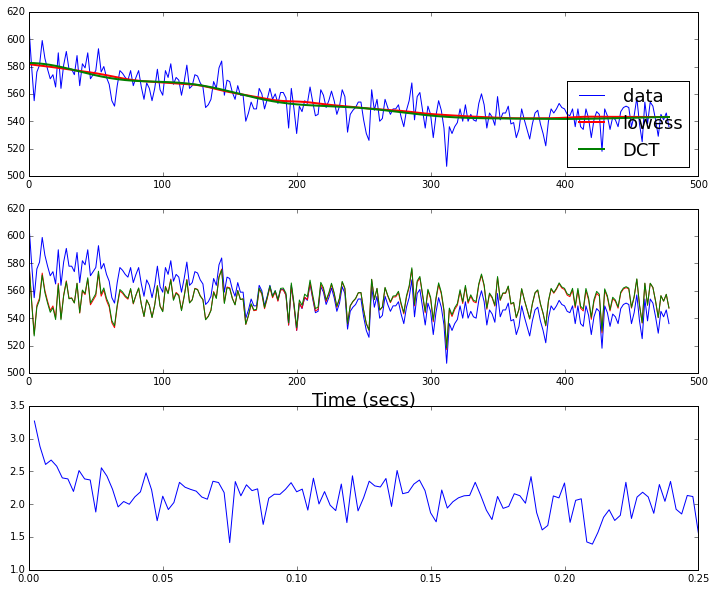

In [123]:
from statsmodels.nonparametric.smoothers_lowess import lowess


power_ts,f = powerspectrum(ts,rate)
power_ts_lowess,_ = powerspectrum(tsfilt_lowess,rate)
power_ts_dct,_ = powerspectrum(tsfilt_dct,rate)


plt.figure(figsize=(12,10))
plt.subplot(3,1,1)
plt.plot(timepoints,ts)
l=lowess(ts,numpy.arange(len(ts)),frac=0.2)
plt.plot(timepoints,l[:,1],linewidth=2,color='red')
dctbases=spm_dctmtx(len(ts),10)
beta=numpy.linalg.lstsq(dctbases,ts)[0]
plt.plot(timepoints,dctbases.dot(beta),linewidth=2,color='green')
plt.legend(['data','lowess','DCT'],loc=4,fontsize=18)

plt.subplot(3,1,2)
plt.plot(timepoints,ts)
tsfilt_lowess=ts-l[:,1]+numpy.mean(ts)
plt.plot(timepoints,tsfilt_lowess,color='red')
tsfilt_dct=ts-dctbases.dot(beta)+numpy.mean(dctbases.dot(beta))
plt.plot(timepoints,tsfilt_dct,color='green')
plt.xlabel('Time (secs)',fontsize=18)

plt.subplot(3,1,3)
print power_ts.shape
print f.shape
plt.plot(f[1:], power_ts[1:])
plt.plot(f[1:],power_ts_lowess[1:],color='red')
plt.plot(f[1:],power_ts_dct[1:],color='green')
plt.xlabel('frequency (Hz)',fontsize=18)
plt.ylabel('log power',fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(figuredir,'Figure_5_15.svg'),format='svg',dpi=1200)

__Figure 5.16__: Illustration of different filtering approaches on blocked designs.

Note: This is not an optimal method for filtering, but I've used it here because it makes it easier to see the differences between the different types of filtering.

In [ ]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_16.pdf'))


running lowpass: 0.1
running highpass: 0.1
running bandpass: [0.05, 0.15]


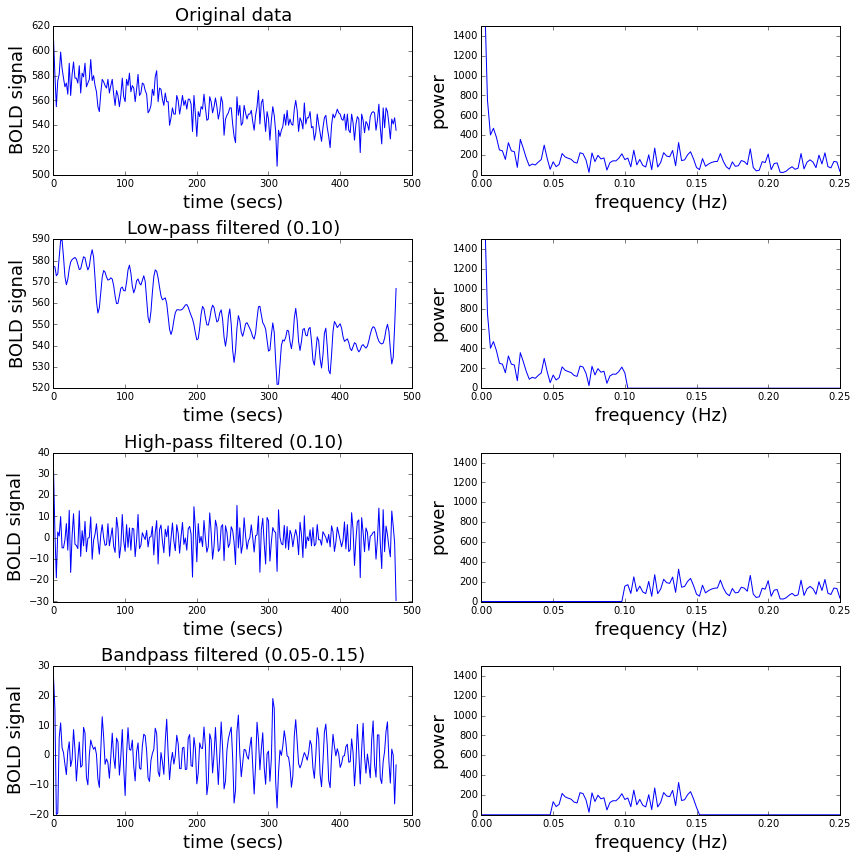

In [122]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 1/2.
lowcut = 0.1
highcut = 0.1
bpcut=[0.05,0.15]


def fft_filter(data,fs,lowpass=None,highpass=None,bandpass=None):
    time=numpy.arange(0,len(data)*(1/fs),1/fs)
    W = numpy.fft.rfftfreq(data.size, d=1/fs)
    f_signal = numpy.fft.rfft(data)
    if not bandpass is None:
        print 'running bandpass:',bandpass
        f_signal[numpy.where(numpy.abs(W)<bandpass[0])]=0
        f_signal[numpy.where(numpy.abs(W)>bandpass[1])]=0
    elif not lowpass is None:
        print 'running lowpass:',lowpass
        f_signal[numpy.where(W>lowpass)]=0
    elif not highpass is None:
        print 'running highpass:',highpass
        f_signal[numpy.where(W<highpass)]=0
    else:
        raise Exception('no filter specified')
    return numpy.fft.irfft(f_signal),W,f_signal # (I), (J), (K) and (L)  

plt.figure(figsize=(12,12))

ts_lpf,freqs,bp_l=fft_filter(ts,fs,lowpass=lowcut)

ts_hpf,_,bp_h=fft_filter(ts,fs,highpass=highcut)

ts_bpf,_,bp_bpf=fft_filter(ts,fs,bandpass=bpcut)


plt.subplot(4,2,1)
plt.plot(timepoints,ts)
plt.xlabel('time (secs)',fontsize=18)
plt.ylabel('BOLD signal',fontsize=18)
plt.title('Original data',fontsize=18)
plt.subplot(4,2,2)
power_ts,f = powerspectrum(ts,rate,log=False)
plt.ylabel('power',fontsize=18)
plt.xlabel('frequency (Hz)',fontsize=18)
plt.plot(f, power_ts)
plt.axis([0,0.25,0,1500])

plt.subplot(4,2,3)
plt.plot(timepoints,ts_lpf)
plt.xlabel('time (secs)',fontsize=18)
plt.ylabel('BOLD signal',fontsize=18)
plt.title('Low-pass filtered (%0.2f)'%lowcut,fontsize=18)

plt.subplot(4,2,4)
power_ts_lpf,f = powerspectrum(ts_lpf,rate,log=False)
plt.ylabel('power',fontsize=18)
plt.xlabel('frequency (Hz)',fontsize=18)
plt.plot(f, power_ts_lpf)
plt.axis([0,0.25,0,1500])

plt.subplot(4,2,5)
plt.plot(timepoints,ts_hpf)
plt.xlabel('time (secs)',fontsize=18)
plt.ylabel('BOLD signal',fontsize=18)
plt.title('High-pass filtered (%0.2f)'%highcut,fontsize=18)

plt.subplot(4,2,6)
power_ts_hpf,f = powerspectrum(ts_hpf,rate,log=False)
plt.ylabel('power',fontsize=18)
plt.xlabel('frequency (Hz)',fontsize=18)
plt.plot(f, power_ts_hpf)
plt.axis([0,0.25,0,1500])

plt.subplot(4,2,7)
plt.plot(timepoints,ts_bpf)
plt.xlabel('time (secs)',fontsize=18)
plt.ylabel('BOLD signal',fontsize=18)
plt.title('Bandpass filtered (%0.2f-%0.2f)'%(bpcut[0],bpcut[1]),fontsize=18)

plt.subplot(4,2,8)
power_ts_bpf,f = powerspectrum(ts_bpf,rate,log=False)
plt.ylabel('power',fontsize=18)
plt.xlabel('frequency (Hz)',fontsize=18)
plt.plot(f, power_ts_bpf)
plt.axis([0,0.25,0,1500])

plt.tight_layout()
plt.savefig(os.path.join(figuredir,'Figure_5_16.svg'),format='svg',dpi=1200)

__Figure 5.17__: Illustration of different filtering approaches on event-related designs

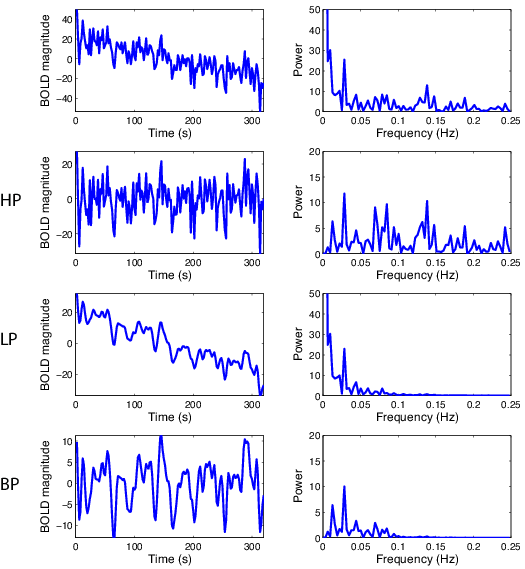

In [24]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_17.pdf'))


running lowpass: 0.1
running highpass: 0.1
running bandpass: [0.05, 0.15]


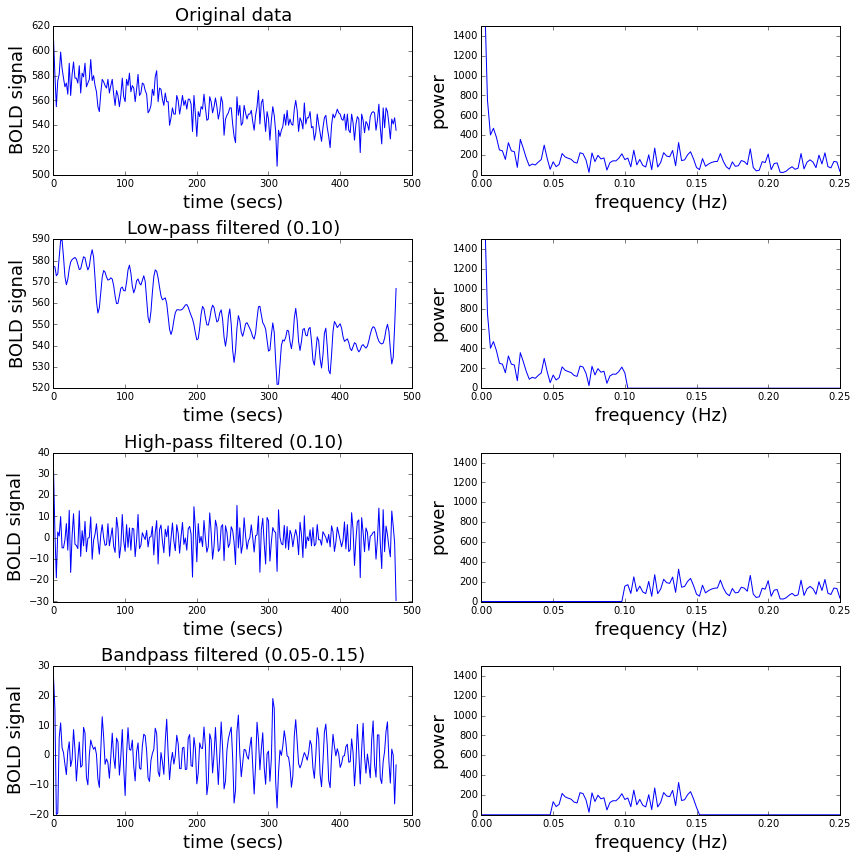

In [121]:
ts=numpy.loadtxt(os.path.join(datadir,'gamm_acc_DM_13_S006_4D_mcf_brain_21_50_13.txt'))
timepoints=numpy.arange(0,2.*len(ts),2.)

ts_lpf,freqs,bp_l=fft_filter(ts,fs,lowpass=lowcut)

ts_hpf,_,bp_h=fft_filter(ts,fs,highpass=highcut)

ts_bpf,_,bp_bpf=fft_filter(ts,fs,bandpass=bpcut)

plt.figure(figsize=(12,12))

plt.subplot(4,2,1)
plt.plot(timepoints,ts)
plt.xlabel('time (secs)',fontsize=18)
plt.ylabel('BOLD signal',fontsize=18)
plt.title('Original data',fontsize=18)
plt.subplot(4,2,2)
power_ts,f = powerspectrum(ts,rate,log=False)
plt.ylabel('power',fontsize=18)
plt.xlabel('frequency (Hz)',fontsize=18)
plt.plot(f, power_ts)
plt.axis([0,0.25,0,1500])

plt.subplot(4,2,3)
plt.plot(timepoints,ts_lpf)
plt.xlabel('time (secs)',fontsize=18)
plt.ylabel('BOLD signal',fontsize=18)
plt.title('Low-pass filtered (%0.2f)'%lowcut,fontsize=18)

plt.subplot(4,2,4)
power_ts_lpf,f = powerspectrum(ts_lpf,rate,log=False)
plt.ylabel('power',fontsize=18)
plt.xlabel('frequency (Hz)',fontsize=18)
plt.plot(f, power_ts_lpf)
plt.axis([0,0.25,0,1500])

plt.subplot(4,2,5)
plt.plot(timepoints,ts_hpf)
plt.xlabel('time (secs)',fontsize=18)
plt.ylabel('BOLD signal',fontsize=18)
plt.title('High-pass filtered (%0.2f)'%highcut,fontsize=18)

plt.subplot(4,2,6)
power_ts_hpf,f = powerspectrum(ts_hpf,rate,log=False)
plt.ylabel('power',fontsize=18)
plt.xlabel('frequency (Hz)',fontsize=18)
plt.plot(f, power_ts_hpf)
plt.axis([0,0.25,0,1500])

plt.subplot(4,2,7)
plt.plot(timepoints,ts_bpf)
plt.xlabel('time (secs)',fontsize=18)
plt.ylabel('BOLD signal',fontsize=18)
plt.title('Bandpass filtered (%0.2f-%0.2f)'%(bpcut[0],bpcut[1]),fontsize=18)

plt.subplot(4,2,8)
power_ts_bpf,f = powerspectrum(ts_bpf,rate,log=False)
plt.ylabel('power',fontsize=18)
plt.xlabel('frequency (Hz)',fontsize=18)
plt.plot(f, power_ts_bpf)
plt.axis([0,0.25,0,1500])

plt.tight_layout()
plt.savefig(os.path.join(figuredir,'Figure_5_17.svg'),format='svg',dpi=1200)

__Figure 5.18__: How jittering can improve model fit

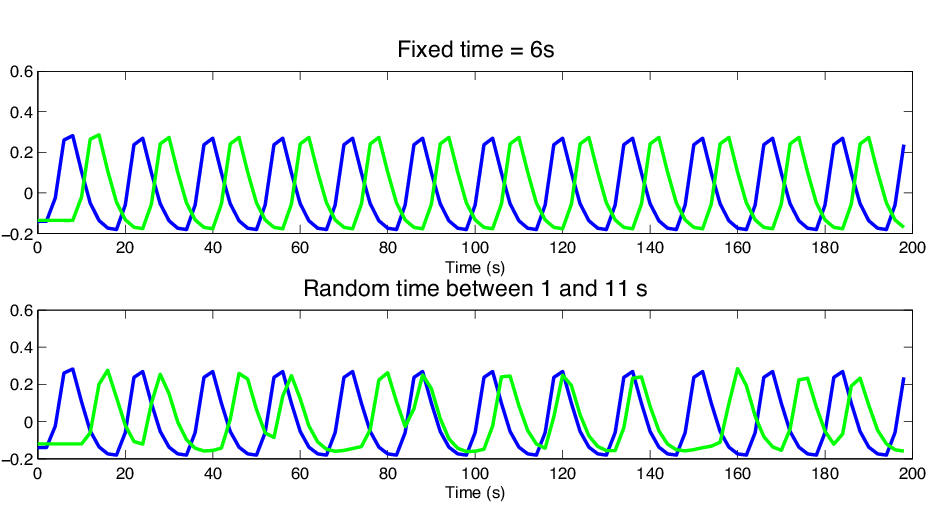

In [25]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_18.pdf'))


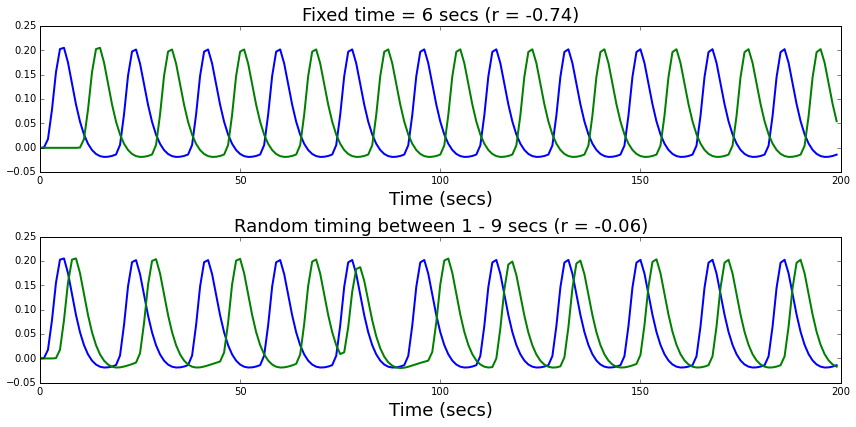

In [120]:
# set seed so that correlation is the same each time
numpy.random.seed(1236)

# generate simulated single-trial data
tslen=200
times=numpy.arange(0,tslen,18)
design=(times,numpy.ones(times.shape),numpy.ones(times.shape))
regressor,_=compute_regressor(design,'spm',numpy.arange(0,tslen))

times2_fixed=times+9
design2_fixed=(times2_fixed,numpy.ones(times.shape),numpy.ones(times.shape))
regressor2_fixed,_=compute_regressor(design2_fixed,'spm',numpy.arange(0,tslen))

times2_random=times+1+numpy.floor(numpy.random.rand(len(times))*9)
design2_random=(times2_random,numpy.ones(times.shape),numpy.ones(times.shape))
regressor2_random,_=compute_regressor(design2_random,'spm',numpy.arange(0,tslen))


plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(regressor,linewidth=2,color='blue')
plt.plot(regressor2_fixed,linewidth=2,color='green')
plt.xlabel('Time (secs)',fontsize=18)
plt.title('Fixed time = 6 secs (r = %0.2f)'%numpy.corrcoef(regressor.T,regressor2_fixed.T)[0,1],fontsize=18)

plt.subplot(2,1,2)
plt.plot(regressor,linewidth=2,color='blue')
plt.plot(regressor2_random,linewidth=2,color='green')
plt.xlabel('Time (secs)',fontsize=18)
plt.title('Random timing between 1 - 9 secs (r = %0.2f)'%numpy.corrcoef(regressor.T,regressor2_random.T)[0,1],fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(figuredir,'Figure_5_18.svg'),format='svg',dpi=1200)